In [169]:
import nltk
import numpy as np
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pprint import pprint
from sklearn import preprocessing

In [170]:
def load_data(files_path):
    
    tagg_sents = []
    sents = []
    taggs = []
    with open(files_path, 'r') as fd:
        # Para cada frase.
        for line in fd.read().split('\n'):
            line_tagg = []
            sent_words = []
            # Para token na frase.
            for token in line.split(" "):
                # Verifica se a palavra está com tagg.
                if token.find("_") > -1:
                    word, tagg = token.split("_")
                else:
                    word = token
                    tagg = "NI"
                line_tagg.append((word, tagg))
                sent_words.append(word)

            tagg_sents.append(line_tagg)
            sents.append(sent_words)
    return tagg_sents, sents

In [171]:
test_taggs, test_sents = load_data("data/macmorpho-test.txt")
train_taggs, train_sents = load_data("data/macmorpho-train.txt")

In [172]:
def unroll(targets, pos=1):

    unrolled_list = []
    for sent in targets:
        unrolled_list += [ "NI" if word[pos] is None else word[pos] for word in sent ]
    return unrolled_list

def unroll_tuples(targets, pos=1):
    unrolled_list = []
    for sent in targets:
        unrolled_list += [ word for word in sent ]
    return unrolled_list

def eval(y_true, y_pred):

    return {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "precision": metrics.precision_score(y_true, y_pred, average="macro"),
        "recall": metrics.recall_score(y_true, y_pred, average="macro"),
        "micro_f1": metrics.f1_score(y_true, y_pred, average="micro"),
        "macro_f1": metrics.f1_score(y_true, y_pred, average="macro")
    }

def plot_cf_matrix(y_true, y_pred):

    le = preprocessing.LabelEncoder()
    plt.figure(figsize=(26,12))
    labels = sorted(set(y_true + y_pred))
    le.fit(labels)
    cf_matrix = confusion_matrix(le.transform(y_true), le.transform(y_pred), normalize="true")
    sns.heatmap(cf_matrix, annot=True, fmt=".2%", cmap="Blues", xticklabels=labels, yticklabels=labels)

In [173]:
y_true = unroll(test_taggs)

In [174]:
scores = {}

In [175]:
def UnigramTaggerEval(train_taggs, test_sents):
    tagger = nltk.UnigramTagger(train_taggs)
    return tagger.tag_sents(test_sents), tagger

def LookupTaggerEval(words, tagged_words, test_sents):

    fd = nltk.FreqDist(words)
    cfd = nltk.ConditionalFreqDist(tagged_words)
    most_freq_words = fd.most_common(100)
    likely_tags = dict((word, cfd[word].max()) for (word, _) in most_freq_words)
    baseline_tagger = nltk.UnigramTagger(model=likely_tags)
    return baseline_tagger.tag_sents(test_sents)

def BigramTaggerEval(train_taggs, test_sents, backoff=None):

    if backoff is None:
        tagger = nltk.BigramTagger(train_taggs)
    else:
        tagger = nltk.BigramTagger(train_taggs, backoff=backoff)
    return tagger.tag_sents(test_sents)

def ClassifierBasedPOSTaggerEval(train_taggs, test_sents):
    
    tagger = nltk.tag.sequential.ClassifierBasedPOSTagger(train=train_taggs)
    return tagger.tag_sents(test_sents)

def BrillTaggerTrainerEval(model_base, train_taggs, test_sents):
    brill_tagger = nltk.BrillTaggerTrainer(model_base, nltk.brill.fntbl37(), trace=True)
    brill_tagger = brill_tagger.train(train_taggs)
    return brill_tagger.tag_sents(test_sents)

In [176]:
pred_taggs, uni_model = UnigramTaggerEval(train_taggs, test_sents)
y_pred = unroll(pred_taggs)
scores["UnigramTagger"] = eval(y_true, y_pred)

/home/welton/NLP/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/welton/NLP/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


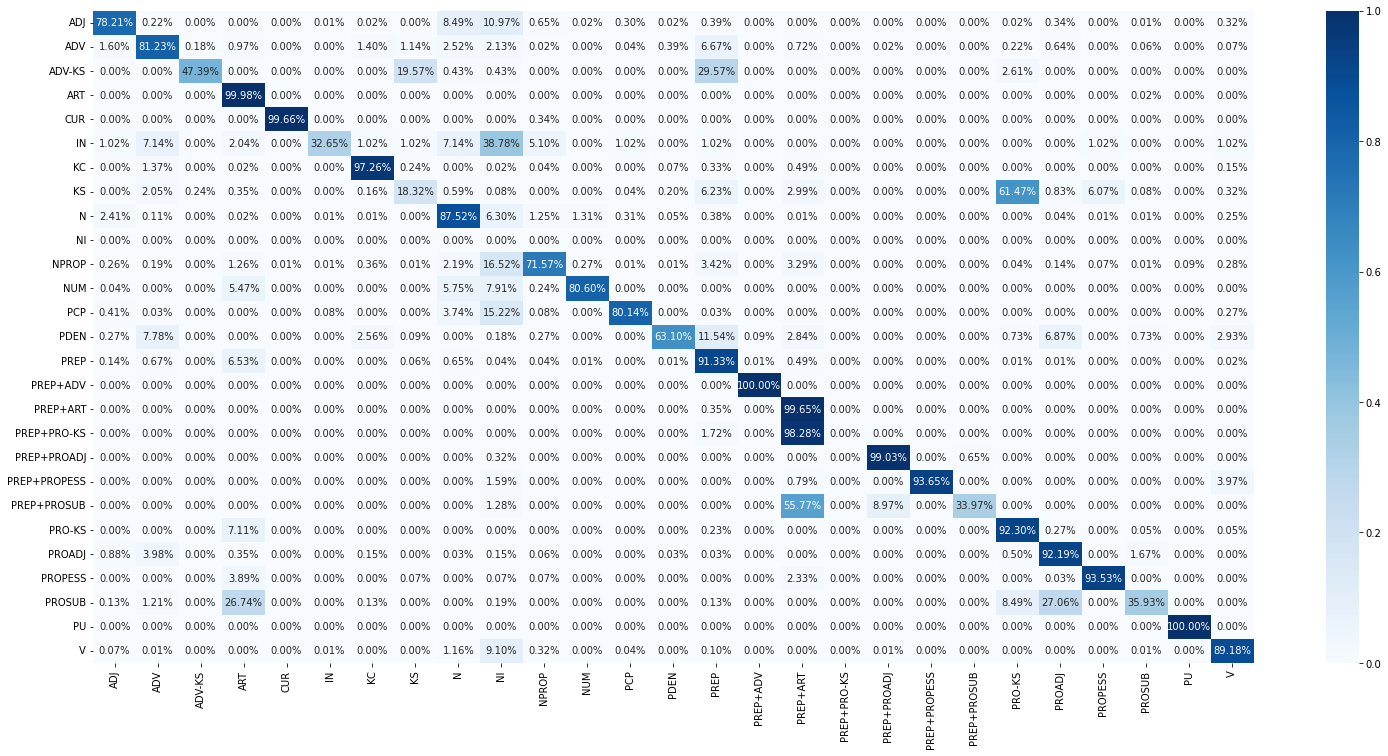

In [177]:
plot_cf_matrix(y_true, y_pred)

In [179]:
pred_taggs = BigramTaggerEval(train_taggs, test_sents)
y_pred = unroll(pred_taggs)
scores["BigramTagger"] = eval(y_true, y_pred)

/home/welton/NLP/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/welton/NLP/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


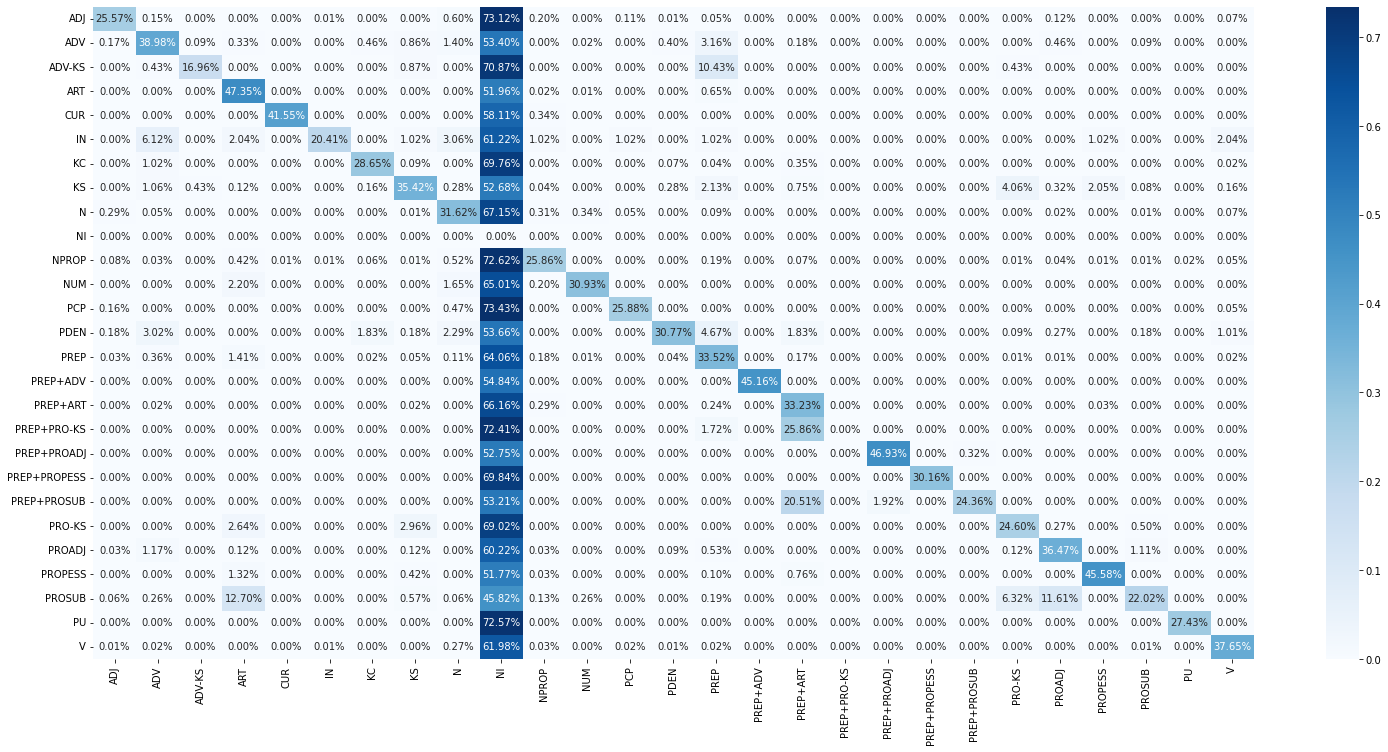

In [180]:
plot_cf_matrix(y_true, y_pred)

In [181]:
pred_taggs = LookupTaggerEval(nltk.corpus.mac_morpho.words(), unroll_tuples(train_taggs), test_sents)
y_pred = unroll(pred_taggs)
scores["LookupTagger"] = eval(y_true, y_pred)

/home/welton/NLP/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/welton/NLP/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [182]:
plot_cf_matrix(y_true, y_pred)

In [ ]:
pred_taggs = ClassifierBasedPOSTaggerEval(train_taggs, test_sents)
y_pred = unroll(pred_taggs)
scores["ClassifierBasedPOSTagger"] = eval(y_true, y_pred)

In [ ]:
plot_cf_matrix(y_true, y_pred)

In [ ]:
BrillTaggerTrainerEval(uni_model, train_taggs, test_sents)
y_pred = unroll(pred_taggs)
scores["BrillTaggerTrainer"] = eval(y_true, y_pred)

In [ ]:
plot_cf_matrix(y_true, y_pred)

In [ ]:
pred_taggs = BigramTaggerEval(train_taggs, test_sents, backoff=uni_model)
y_pred = unroll(pred_taggs)
print(eval(y_true, y_pred))
scores["BigramTaggerBackoff"] = eval(y_true, y_pred)

In [ ]:
plot_cf_matrix(y_true, y_pred)